# Optimizing DVD Inventory with Rental Forecasting

![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to **figure out how many days a customer will rent a DVD for** based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which **yields a MSE of 3 or less on a test set**. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Length of the movie being rented, in minutes.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convenience, the reference dummy has already been dropped.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, VotingRegressor

# Random seed for reproducibility
SEED = 9

# Load the dataset
df = pd.read_csv('rental_info.csv')

- EDA

In [2]:
df.sample(5)

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
1678,2005-07-09 22:18:49+00:00,2005-07-15 02:16:49+00:00,2.99,2006.0,2.99,84.0,23.99,"{Trailers,Commentaries}",1,0,0,0,8.9401,7056.0,8.9401
7656,2005-07-11 04:16:35+00:00,2005-07-20 05:30:35+00:00,9.99,2006.0,4.99,56.0,22.99,"{""Deleted Scenes""}",0,1,0,0,99.8001,3136.0,24.9001
6424,2005-08-17 14:25:53+00:00,2005-08-22 12:37:53+00:00,3.99,2005.0,2.99,90.0,18.99,"{""Deleted Scenes""}",0,0,1,0,15.9201,8100.0,8.9401
4347,2005-08-19 13:55:20+00:00,2005-08-24 08:10:20+00:00,4.99,2005.0,4.99,103.0,29.99,"{Trailers,""Behind the Scenes""}",0,0,1,0,24.9001,10609.0,24.9001
10942,2005-05-30 10:41:32+00:00,2005-05-31 11:39:32+00:00,4.99,2009.0,4.99,111.0,28.99,"{""Deleted Scenes""}",0,0,0,1,24.9001,12321.0,24.9001


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


In [4]:
df['special_features'].unique()

array(['{Trailers,"Behind the Scenes"}', '{Trailers}',
       '{Commentaries,"Behind the Scenes"}', '{Trailers,Commentaries}',
       '{"Deleted Scenes","Behind the Scenes"}',
       '{Commentaries,"Deleted Scenes","Behind the Scenes"}',
       '{Trailers,Commentaries,"Deleted Scenes"}',
       '{"Behind the Scenes"}',
       '{Trailers,"Deleted Scenes","Behind the Scenes"}',
       '{Commentaries,"Deleted Scenes"}', '{Commentaries}',
       '{Trailers,Commentaries,"Behind the Scenes"}',
       '{Trailers,"Deleted Scenes"}', '{"Deleted Scenes"}',
       '{Trailers,Commentaries,"Deleted Scenes","Behind the Scenes"}'],
      dtype=object)

In [5]:
df.describe(include=np.number)

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
count,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000
mean,4.217161,2006.885379,2.944101,114.994578,20.224727,0.204842,0.200303,0.223378,0.198726,23.355504,14832.841876,11.389287
std,2.360383,2.025027,1.649766,40.114715,6.083784,0.403599,0.400239,0.416523,0.399054,23.503164,9393.431996,10.005293
min,0.990000,2004.000000,0.990000,46.000000,9.990000,0.000000,0.000000,0.000000,0.000000,0.980100,2116.000000,0.980100
25%,2.990000,2005.000000,0.990000,81.000000,14.990000,0.000000,0.000000,0.000000,0.000000,8.940100,6561.000000,0.980100
50%,3.990000,2007.000000,2.990000,114.000000,20.990000,0.000000,0.000000,0.000000,0.000000,15.920100,12996.000000,8.940100
75%,4.990000,2009.000000,4.990000,148.000000,25.990000,0.000000,0.000000,0.000000,0.000000,24.900100,21904.000000,24.900100
max,11.990000,2010.000000,4.990000,185.000000,29.990000,1.000000,1.000000,1.000000,1.000000,143.760100,34225.000000,24.900100


In [6]:
df.isna().sum()

rental_date         0
return_date         0
amount              0
release_year        0
rental_rate         0
length              0
replacement_cost    0
special_features    0
NC-17               0
PG                  0
PG-13               0
R                   0
amount_2            0
length_2            0
rental_rate_2       0
dtype: int64

c:\Users\tseng\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


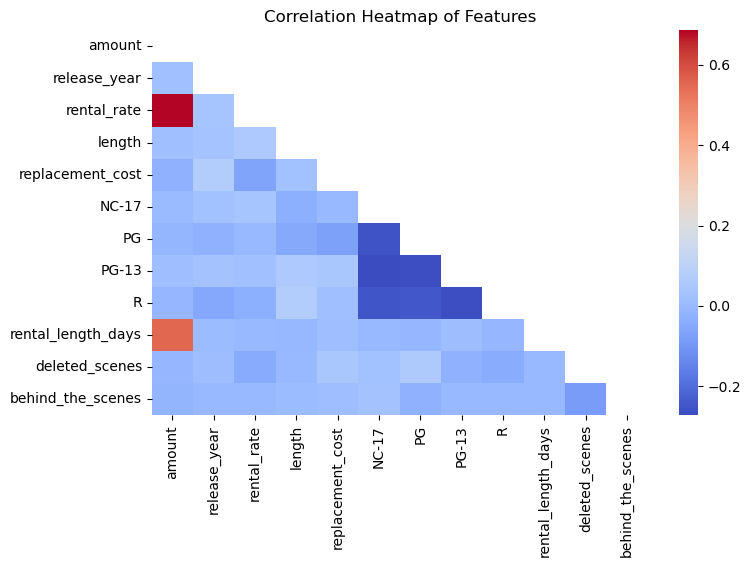

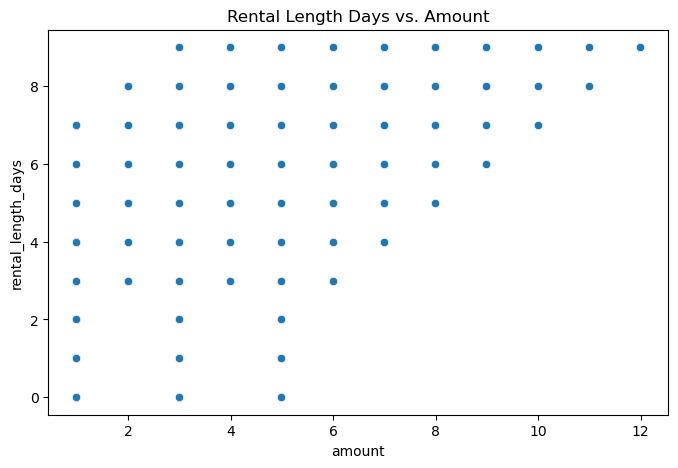

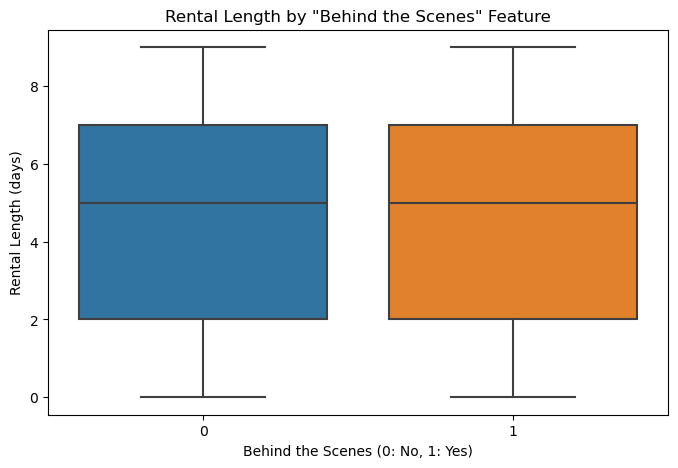

T-test between movies with and without 'Behind the Scenes':
T-statistic: -0.007, p-value: 0.994 > 0.05. 
Our null hypothesis is that the two groups have the same mean value for the rental lengths. 
Since the p-value > 0.05, the null hypothesis holds.


In [7]:
# ==============================
# 1. Data Preprocessing
# ==============================

# Feature engineering: Convert to cols to datetime, calculate rental_day_length
df['rental_date'] = pd.to_datetime(df['rental_date'])
df['return_date'] = pd.to_datetime(df['return_date'])
df['rental_length_days'] = (df['return_date'] - df['rental_date']).dt.days

# OneHotEncoding: Create 2 columns of dummy variables for special features
df['special_features'] = df['special_features'].astype('str')
df['deleted_scenes'] = np.where(df['special_features'].str.contains('Deleted Scenes'), 1, 0)
df['behind_the_scenes'] = np.where(df['special_features'].str.contains('Behind the Scenes'), 1, 0)

# Data cleaning
subset = df.drop(columns=[
    'rental_date', 'return_date', 'special_features', 'amount_2', 'rental_rate_2', 'length_2'
    ], errors='ignore'
)

X = subset.drop(columns='rental_length_days', errors='ignore')
y = subset['rental_length_days']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# ==============================
# 2. Feature Selection using Lasso
# ==============================
lasso = Lasso(alpha=0.01, random_state=SEED, tol=0.0001, max_iter=1000)
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_

# Select features with non-zero coefficients
selected_features = X_train.columns[lasso_coef > 0]
X_train_sel = X_train[selected_features]
X_test_sel  = X_test[selected_features]

# ==============================
# 3. Data Visualization
# ==============================

# Plot correlation heatmap among numeric features
plt.figure(figsize=(8, 5))
corr = subset.corr() 
mask = np.triu(np.ones_like(corr, dtype=bool)) # Only show to lower half of the heatmap for a cleaner plot
sns.heatmap(corr, annot=True, cmap="coolwarm", mask=mask)
plt.title('Correlation Heatmap of Features')
plt.show()

# Make scatterplots to verify caveats of pearson-r coef.
plt.figure(figsize=(8, 5))
sns.scatterplot(x='amount', y='rental_length_days', data=df)
plt.title('Rental Length Days vs. Amount')
plt.show()

# Boxplot of rental_length_days by one of the dummy variables (e.g., behind_the_scenes)
plt.figure(figsize=(8, 5))
sns.boxplot(x=X['behind_the_scenes'], y=y)
plt.title('Rental Length by "Behind the Scenes" Feature')
plt.xlabel('Behind the Scenes (0: No, 1: Yes)')
plt.ylabel('Rental Length (days)')
plt.show()

# ==============================
# 4. Statistical Test
# ==============================

# Test if movies with behind the scenes have different rental lengths
from scipy.stats import ttest_ind

group1 = y[X['behind_the_scenes'] == 1]
group2 = y[X['behind_the_scenes'] == 0]

t_stat, p_value = ttest_ind(group1, group2, equal_var=False)

print("T-test between movies with and without 'Behind the Scenes':")
print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.3f} > 0.05. ")
print('Our null hypothesis is that the two groups have the same mean value for the rental lengths. ')
print('Since the p-value > 0.05, the null hypothesis holds.')


MSE for LinearRegression: 4.847
Best params for DecisionTreeRegressor: {'min_samples_leaf': 0.01, 'max_features': 0.38421052631578945, 'max_depth': 38}
MSE for DecisionTreeRegressor: 4.205


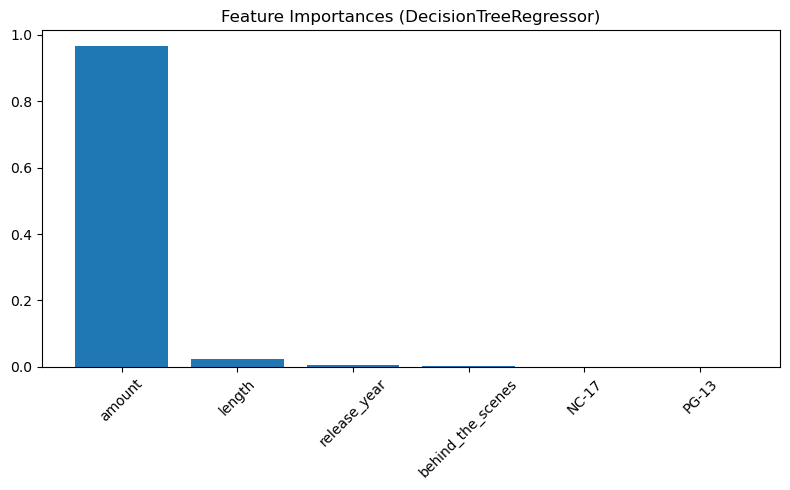

Best params for RandomForestRegressor: {'n_estimators': 100, 'min_samples_leaf': 0.01, 'max_features': 'sqrt', 'max_depth': 11}
MSE for RandomForestRegressor: 4.228


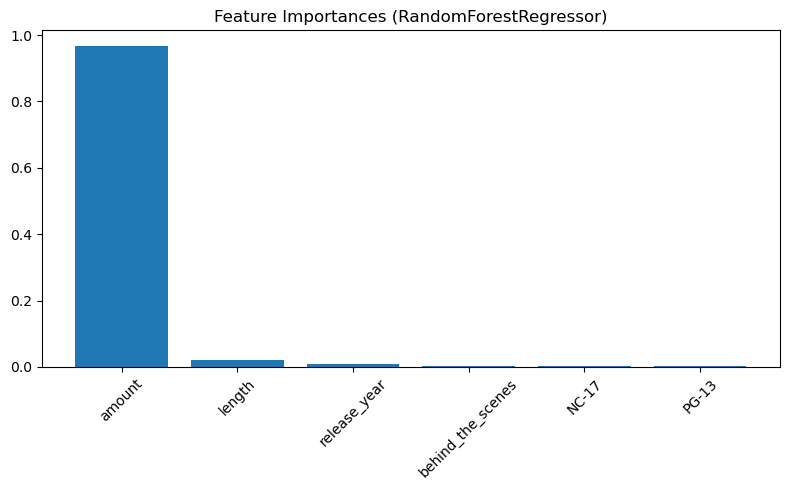

Best params for GradientBoostingRegressor: {'subsample': 0.9210526315789473, 'n_estimators': 300, 'min_samples_leaf': 0.15000000000000002, 'max_features': 1, 'max_depth': 6}
MSE for GradientBoostingRegressor: 4.055


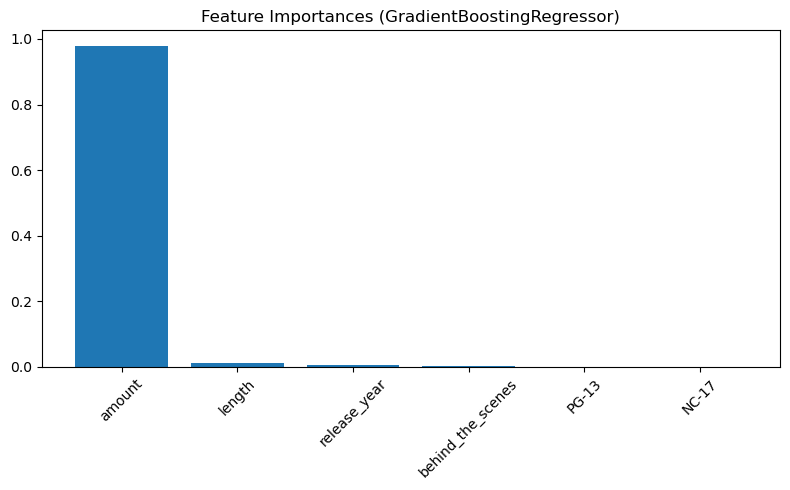

Best params for BaggingRegressor: {'oob_score': True, 'n_estimators': 400, 'max_samples': 0.7222222222222222, 'max_features': 1.0, 'bootstrap_features': False, 'bootstrap': True}
MSE for BaggingRegressor: 2.408
Best params for Lasso: {'tol': 0.01, 'max_iter': 1000, 'alpha': 0.0062505519252739694}
MSE for Lasso: 4.846
Voting Regressor MSE: 2.736


c:\Users\tseng\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


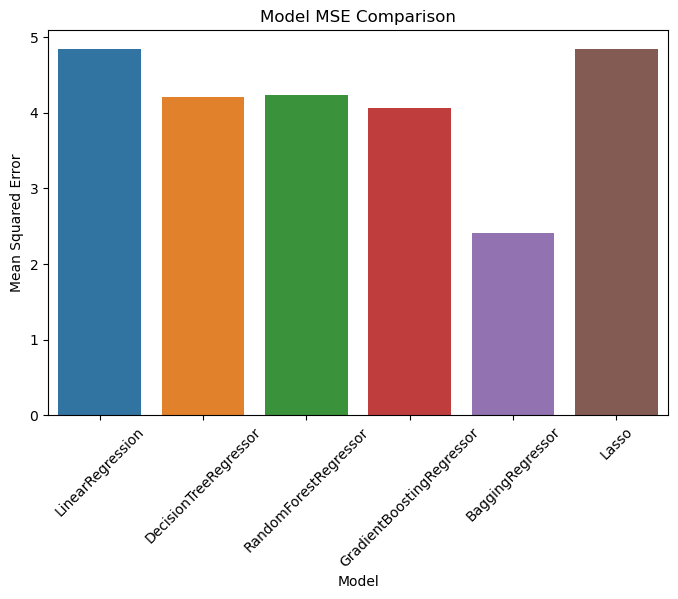

In [8]:
# ==============================
# 5. Model Training, Hyperparameter Tuning & Voting Regressor
# ==============================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

# Initialise models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=SEED)
rf = RandomForestRegressor(random_state=SEED)
gbr = GradientBoostingRegressor(random_state=SEED)
br = BaggingRegressor(random_state=SEED)

models = [lr, dt, rf, gbr, br, lasso]
mse = []

# Initialise param_grids for different models
params_dt = {
    'max_depth': range(1, 50),
    'min_samples_leaf': np.linspace(0.01, 0.5, 50),
    'max_features': np.linspace(0.1, 1.0, 20)
}

params_rf = {
    'n_estimators': range(100, 500, 100),
    'max_depth': range(1, 20),
    'min_samples_leaf': np.linspace(0.01, 0.5, 50),
    'max_features': ['auto', 'sqrt', 'log2']
}

params_gbr = {
    'n_estimators': range(100, 500, 100),
    'max_depth': range(1, 15),
    'min_samples_leaf': np.linspace(0.01, 0.5, 50),
    'max_features': [1, 'sqrt', 'log2'],
    'subsample': np.linspace(0.5, 1.0, 20)
}

params_br = {
    'n_estimators': range(100, 500, 100),
    'max_features': np.linspace(0.1, 1.0, 10),
    'max_samples': np.linspace(0.5, 1.0, 10),
    'bootstrap': [True],
    'bootstrap_features': [True, False],
    'oob_score': [True, False]
}

params_lasso = {
    'alpha': np.logspace(-4, 0, 50),
    'max_iter': [1000, 5000, 10000],
    'tol': [1e-4, 1e-3, 1e-2]
}

# Mapping models to parameter grids
model_params = {
    lr: None,
    dt: params_dt,
    rf: params_rf,
    gbr: params_gbr,
    br: params_br,
    lasso: params_lasso
}

# Evaluate and tune each model
for model, grid in model_params.items():
    if grid:
        cv = RandomizedSearchCV(model, grid, random_state=SEED, cv=10, n_iter=10, n_jobs=-1)
        cv.fit(X_train_scaled, y_train)
        best_model = cv.best_estimator_
        print(f'Best params for {model.__class__.__name__}: {cv.best_params_}')
    else:
        best_model = model
        best_model.fit(X_train_scaled, y_train)
    
    y_pred = best_model.predict(X_test_scaled)
    mse_value = MSE(y_test, y_pred)
    mse.append(mse_value)
    print(f"MSE for {best_model.__class__.__name__}: {mse_value:.3f}")

    # Plot feature importance if the model supports it
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(8, 5))
        plt.title(f"Feature Importances ({best_model.__class__.__name__})")
        plt.bar(range(len(selected_features)), importances[indices], align="center")
        plt.xticks(range(len(selected_features)), np.array(selected_features)[indices], rotation=45)
        plt.tight_layout()
        plt.show()

# Using the best tuned models from our list
voting_regressor = VotingRegressor(estimators=[
    ('lr', lr), 
    ('dt', dt), 
    ('rf', rf), 
    ('gbr', gbr),
    ('br', br),
    ('lasso', lasso)
])

# Fit ensemble model
voting_regressor.fit(X_train_scaled, y_train)
y_pred_vote = voting_regressor.predict(X_test_scaled)
voting_mse = MSE(y_test, y_pred_vote)
print(f"Voting Regressor MSE: {voting_mse:.3f}")

# ==============================
# 6. Model Interpretation & Visualization
# ==============================

# Plot MSE for all models
model_names = [model.__class__.__name__ for model in model_params.keys()]
plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=mse)
plt.title("Model MSE Comparison")
plt.xlabel("Model")
plt.ylabel("Mean Squared Error")
plt.xticks(rotation=45)
plt.show()
